# Predicting blood-brain barrier permeability (BBBP) <br> with an attention model

We're going to train an attention-based neural network to predict whether a given molecule can permeate through the [blood-brain barrier](https://en.wikipedia.org/wiki/Blood%E2%80%93brain_barrier).

We'll use the BBBP dataset (as curated by [MoleculeNet](https://moleculenet.org/datasets-1)) for this purpose.

Some initial imports:

In [1]:
# Import required libraries for data analysis and visualisation

import sys
import os
from io import StringIO
from collections import Counter, defaultdict, namedtuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import h5py
import json

import rdkit as rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmilesFromSmiles
from rdkit import RDLogger

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import roc_auc_score, roc_curve

### Define functions for preprocessing the data

I did not write these!

In [2]:
# Define some functions that we need for processing data.
# Note: Original source for the utility functions used below is
# https://blog.reverielabs.com/mapping-chemical-space-with-umap/

def get_largest_fragment_from_smiles(s: str):
    mol = Chem.MolFromSmiles(s)
    if mol:
        clean_mol = LargestFragmentChooser().choose(mol)
        return Chem.MolToSmiles(clean_mol)
    return None

def compute_ecfp_descriptors(smiles_list):
    """ Computes ecfp descriptors """
    
    keep_idx = []
    descriptors = []
    for i, smiles in enumerate(smiles_list):
        ecfp = _compute_single_ecfp_descriptor(smiles)
        if ecfp is not None:
            keep_idx.append(i)
            descriptors.append(ecfp)

    return np.vstack(descriptors), keep_idx

def _compute_single_ecfp_descriptor(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None

    if mol:
        fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return np.array(fp)
    
    return None

### Downloading and cleaning up the data

In [3]:
# Get data from MoleculeNet 
# (Unless we've already downloaded it)
try:
    bbbp = pd.read_csv("BBBP.csv", sep="\t")
except:
    bbbp = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv")
    bbbp.to_csv("BBBP.csv",sep="\t",index=False)

In [4]:
# Change column name "p_np" to "permeable" for a better readibility
bbbp = bbbp[["smiles", "p_np", "name"]].reset_index(drop=True).rename({"p_np": "permeable"}, axis=1)

# Remove extra fragments in SMILES since they are not relevant to BBB permeability
bbbp["smiles"] = bbbp["smiles"].apply(get_largest_fragment_from_smiles).dropna()

RDKit INFO: [16:20:54] Running LargestFragmentChooser
RDKit INFO: [16:20:54] Fragment: [Cl]
RDKit INFO: [16:20:54] New largest fragment: [Cl] (1)
RDKit INFO: [16:20:54] Fragment: CC(C)NCC(O)COc1cccc2ccccc12
RDKit INFO: [16:20:54] New largest fragment: CC(C)NCC(O)COc1cccc2ccccc12 (40)
RDKit INFO: [16:20:54] Running LargestFragmentChooser
RDKit INFO: [16:20:54] Fragment: CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1
RDKit INFO: [16:20:54] New largest fragment: CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1 (50)
RDKit INFO: [16:20:54] Running LargestFragmentChooser
RDKit INFO: [16:20:54] Fragment: CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23
RDKit INFO: [16:20:54] New largest fragment: CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23 (46)
RDKit INFO: [16:20:54] Running LargestFragmentChooser
RDKit INFO: [16:20:54] Fragment: CC(=O)NCCCOc1cccc(CN2CCCCC2)c1
RDKit INFO: [16:20:54] New largest fragment: CC(=O)NCCCOc1cccc(CN2CCCCC2)c1 (47)
RDKit INFO: [16:20:54] Running LargestFragmentChooser
RDKit INFO: 

RDKit INFO: [16:20:54] New largest fragment: CN1CCN2c3ncccc3Cc3ccccc3C2C1 (39)
RDKit INFO: [16:20:54] Running LargestFragmentChooser
RDKit INFO: [16:20:54] Fragment: Cc1ccnc2c1NC(=O)c1cccnc1N2C1CC1
RDKit INFO: [16:20:54] New largest fragment: Cc1ccnc2c1NC(=O)c1cccnc1N2C1CC1 (34)
RDKit INFO: [16:20:54] Running LargestFragmentChooser
RDKit INFO: [16:20:54] Fragment: FC(F)(F)c1ccc(N2CCNCC2)nc1Cl
RDKit INFO: [16:20:54] New largest fragment: FC(F)(F)c1ccc(N2CCNCC2)nc1Cl (28)
RDKit INFO: [16:20:54] Running LargestFragmentChooser
RDKit INFO: [16:20:54] Fragment: Clc1ccc2c(c1)[C@H]1CNC[C@H]1c1ccccc1O2
RDKit INFO: [16:20:54] New largest fragment: Clc1ccc2c(c1)[C@H]1CNC[C@H]1c1ccccc1O2 (33)
RDKit INFO: [16:20:54] Running LargestFragmentChooser
RDKit INFO: [16:20:54] Fragment: Cc1cccc2c1Oc1ccccc1[C@@]1(O)CCNC[C@H]21
RDKit INFO: [16:20:54] New largest fragment: Cc1cccc2c1Oc1ccccc1[C@@]1(O)CCNC[C@H]21 (40)
RDKit INFO: [16:20:54] Running LargestFragmentChooser
RDKit INFO: [16:20:54] Fragment: C=CC[C

RDKit INFO: [16:20:54] Fragment: OCCN1CCN(CCCN2c3ccccc3Sc3ccc(C(F)(F)F)cc32)CC1
RDKit INFO: [16:20:54] New largest fragment: OCCN1CCN(CCCN2c3ccccc3Sc3ccc(C(F)(F)F)cc32)CC1 (56)
RDKit INFO: [16:20:54] Running LargestFragmentChooser
RDKit INFO: [16:20:54] Fragment: CCN(CC)CCN1C(=O)CN=C(c2ccccc2F)c2cc(Cl)ccc21
RDKit INFO: [16:20:54] New largest fragment: CCN(CC)CCN1C(=O)CN=C(c2ccccc2F)c2cc(Cl)ccc21 (50)
RDKit INFO: [16:20:54] Running LargestFragmentChooser
RDKit INFO: [16:20:54] Fragment: COc1cc2c3c(c1O)C1(C=CC(=O)C=C1)CC3N(C)CC2
RDKit INFO: [16:20:54] New largest fragment: COc1cc2c3c(c1O)C1(C=CC(=O)C=C1)CC3N(C)CC2 (41)
RDKit INFO: [16:20:54] Running LargestFragmentChooser
RDKit INFO: [16:20:54] Fragment: CCC1(c2ccccc2)CCC(=O)NC1=O
RDKit INFO: [16:20:54] New largest fragment: CCC1(c2ccccc2)CCC(=O)NC1=O (31)
RDKit INFO: [16:20:54] Running LargestFragmentChooser
RDKit INFO: [16:20:54] Fragment: O=C(CCCN1CCC(O)(c2ccc(Cl)cc2)CC1)c1ccc(F)cc1
RDKit INFO: [16:20:54] New largest fragment: O=C(CCC

RDKit INFO: [16:20:54] New largest fragment: COCOC(=O)C1N2C(=O)C(N3C(=O)C(c4ccc(O)cc4)NC3(C)C)C2SC1(C)C (58)
RDKit INFO: [16:20:54] Running LargestFragmentChooser
RDKit INFO: [16:20:54] Fragment: COCOC(=O)[C@@H]1N2C(=O)[C@@H](N3C(=O)C(c4ccccc4)NC3(C)C)[C@H]2SC1(C)C
RDKit INFO: [16:20:54] New largest fragment: COCOC(=O)[C@@H]1N2C(=O)[C@@H](N3C(=O)C(c4ccccc4)NC3(C)C)[C@H]2SC1(C)C (57)
RDKit INFO: [16:20:54] Running LargestFragmentChooser
RDKit INFO: [16:20:54] Fragment: CC(=O)OC1/C=C/C(C)=C/CC(O)/C=C/C(C)=C/C(NC(=O)C(C)=O)C2(C)C(=O)OC(C1)C(C)C2=O
RDKit INFO: [16:20:54] New largest fragment: CC(=O)OC1/C=C/C(C)=C/CC(O)/C=C/C(C)=C/C(NC(=O)C(C)=O)C2(C)C(=O)OC(C1)C(C)C2=O (71)
RDKit INFO: [16:20:54] Running LargestFragmentChooser
RDKit INFO: [16:20:54] Fragment: CN[C@@H]1[C@@H](O)[C@@H](O[C@@H]2[C@@H](O)[C@H](O[C@H]3OC(CN)=CC[C@H]3N)[C@@H](N)C[C@H]2N)OC[C@]1(C)O
RDKit INFO: [16:20:54] New largest fragment: CN[C@@H]1[C@@H](O)[C@@H](O[C@@H]2[C@@H](O)[C@H](O[C@H]3OC(CN)=CC[C@H]3N)[C@@H](N)C[C@H]

RDKit INFO: [16:20:55] Running LargestFragmentChooser
RDKit INFO: [16:20:55] Fragment: O=C(NCCN1CCC(n2c(=O)[nH]c3cc(Cl)ccc32)CC1)c1ccc(F)cc1
RDKit INFO: [16:20:55] New largest fragment: O=C(NCCN1CCC(n2c(=O)[nH]c3cc(Cl)ccc32)CC1)c1ccc(F)cc1 (51)
RDKit INFO: [16:20:55] Running LargestFragmentChooser
RDKit INFO: [16:20:55] Fragment: CCCCCCCCCC(=O)OC1(c2ccc(Cl)cc2)CCN(CCCC(=O)c2ccc(F)cc2)CC1
RDKit INFO: [16:20:55] New largest fragment: CCCCCCCCCC(=O)OC1(c2ccc(Cl)cc2)CCN(CCCC(=O)c2ccc(F)cc2)CC1 (78)
RDKit INFO: [16:20:55] Running LargestFragmentChooser
RDKit INFO: [16:20:55] Fragment: C[C@]12C=C(Br)C(=O)C=C1[C@H](F)C[C@H]1[C@@H]3CCC(O)(C(=O)CO)[C@@]3(C)C[C@H](O)C12F
RDKit INFO: [16:20:55] New largest fragment: C[C@]12C=C(Br)C(=O)C=C1[C@H](F)C[C@H]1[C@@H]3CCC(O)(C(=O)CO)[C@@]3(C)C[C@H](O)C12F (54)
RDKit INFO: [16:20:55] Running LargestFragmentChooser
RDKit INFO: [16:20:55] Fragment: O=C1CN2CCOC2(c2ccccc2F)c2cc(Br)ccc2N1
RDKit INFO: [16:20:55] New largest fragment: O=C1CN2CCOC2(c2ccccc2F)c2cc

RDKit INFO: [16:20:55] Running LargestFragmentChooser
RDKit INFO: [16:20:55] Fragment: CCCC(O)Cl
RDKit INFO: [16:20:55] New largest fragment: CCCC(O)Cl (15)
RDKit INFO: [16:20:55] Running LargestFragmentChooser
RDKit INFO: [16:20:55] Fragment: CC(=O)OCC(=O)[C@@]1(O)CC[C@H]2[C@@H]3C[C@H](Cl)C4=CC(=O)C=C[C@]4(C)[C@H]3C(=O)C[C@@]21C
RDKit INFO: [16:20:55] New largest fragment: CC(=O)OCC(=O)[C@@]1(O)CC[C@H]2[C@@H]3C[C@H](Cl)C4=CC(=O)C=C[C@]4(C)[C@H]3C(=O)C[C@@]21C (57)
RDKit INFO: [16:20:55] Running LargestFragmentChooser
RDKit INFO: [16:20:55] Fragment: COC(=O)[C@H]1[C@H]2C[C@@H]3c4[nH]c5ccc(Cl)cc5c4CCN3C[C@H]2C[C@@H](OC(=O)c2cc(OC)c(OC)c(OC)c2)[C@@H]1OC
RDKit INFO: [16:20:55] New largest fragment: COC(=O)[C@H]1[C@H]2C[C@@H]3c4[nH]c5ccc(Cl)cc5c4CCN3C[C@H]2C[C@@H](OC(=O)c2cc(OC)c(OC)c(OC)c2)[C@@H]1OC (80)
RDKit INFO: [16:20:55] Running LargestFragmentChooser
RDKit INFO: [16:20:55] Fragment: NC(=O)OCC(O)COc1ccc(Cl)cc1
RDKit INFO: [16:20:55] New largest fragment: NC(=O)OCC(O)COc1ccc(Cl)cc1 (

In [5]:
# Compute descriptors while keeping track of the ones that failed
ecfp_descriptors, keep_idx = compute_ecfp_descriptors(bbbp["smiles"])

# Keep only the ones that we were able to generate features for
bbbp = bbbp.iloc[keep_idx]

In [6]:
# Reset the index of the DataFrame to be a contiguous range.
bbbp.index = range(bbbp.shape[0])

### Encoding the samples

We're going to translate the molecules' SMILES strings into encodings that are useful for deep learning:

* One-hot encodings for atoms
* Thermometer encodings for bonds
* Pairwise Euclidean distances between atoms

We'll store the results to disk for convenience. 

Downstream, the `Dataset` objects will retrieve this information as needed.

First, though, we will need to find the number of unique atomic symbols and bond types in this dataset.

In [7]:
# First, find all the unique atomic symbols and bond types in our dataset.

def collect_unique_symbols(smiles_vec):
    """
    Find the unique atomic symbols and bond types in a collection of SMILES strings.
    """
    unique_symbols = set()
    unique_bond_types = set()
    for smiles in smiles_vec:
        mol = Chem.MolFromSmiles(smiles)
        for atom in mol.GetAtoms():
            unique_symbols.add(atom.GetSymbol())
        for bond in mol.GetBonds():
            unique_bond_types.add(bond.GetBondType())
        
    return unique_symbols, unique_bond_types


unique_symbols, unique_bond_types = collect_unique_symbols(bbbp["smiles"].values)

# Define a canonical mapping from atomic symbols to integers.
symbol_enum = {s:idx for idx, s in enumerate(sorted(list(unique_symbols)))}
ATOM_DIM = len(symbol_enum)

# Define a mapping from bond types to integers.
# The enum orders bond types (roughly) by their strength. 
# `unique_bond_types` shows that these are the only bonds present in the dataset.
bond_enum = {'SINGLE': 0, 'AROMATIC':1, 'DOUBLE': 2, 'TRIPLE': 3}
BOND_DIM = len(bond_enum)

In [8]:
def smiles_to_node_df(smiles):
    """
    Convert a SMILES string to a dataframe of 
    nodewise data: atomic symbol and (x,y,z) coordinates.
    """
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    
    embed_exit_code = 1
    retries = 0
    while embed_exit_code != 0:
        embed_exit_code = Chem.AllChem.EmbedMolecule(mol)
        if embed_exit_code != 0:
            retries += 1
        if retries >= 10:
            raise RuntimeError()
            
    mol = Chem.RemoveHs(mol)
    block = Chem.MolToXYZBlock(mol)
    newblock = "\n".join(["\t".join(line.split()) for line in block.split("\n")])
    df = pd.read_csv(StringIO(newblock), sep="\t", skiprows=[0], header=None)
    return df


def encode_atom_symbols(symbol_vec):
    """
    Convert an N-dim vector of atom symbols to a
    N x D matrix of one-hot encodings.
    """
    result = np.zeros((len(symbol_vec), len(symbol_enum)))
    for i, symbol in enumerate(symbol_vec):
        result[i, symbol_enum[symbol]] = 1.0
    return result


def encode_edges(smiles):
    """
    Given a SMILES string, encode its bond types
    and construct an adjacency matrix.
    """
    mol = Chem.MolFromSmiles(smiles)
    N_atom = mol.GetNumAtoms()
    N_bond = mol.GetNumBonds()
    adjacency = np.identity(N_atom)
    bonds = np.zeros((N_bond, 2 + len(unique_bond_types)))
    
    for i, bond in enumerate(mol.GetBonds()):
        # Get the edge/adjacency information
        u = bond.GetBeginAtomIdx()
        v = bond.GetEndAtomIdx()
        adjacency[u,v] = 1
        adjacency[v,u] = 1
        
        # Encode the bond type using "thermometer" encoding
        bt = str(bond.GetBondType())
        bonds[i,0] = u
        bonds[i,1] = v
        bonds[i,2:(3+bond_enum[bt])] = 1
        
    return adjacency, bonds

    
def compute_pairwise_distances(xyz_array):
    """
    From an N x 3 array of atom coordinates,
    construct an N x N matrix of pairwise distances.
    
    I realize that these distances can vary if there are multiple conformers.
    It could be interesting or worthwhile to compute the distances several times
    and generate aggregate values (e.g., means or medians).
    """
    N = xyz_array.shape[0]
    diffsq = np.zeros((N,N))
    
    for j in range(xyz_array.shape[1]):
        jdiff = np.subtract.outer(xyz_array[:,j], xyz_array[:,j])
        jdiff *= jdiff
        diffsq += jdiff
    
    return np.sqrt(diffsq)


def _extract_information_from_smiles(uuid, smiles, hdf_file):
    """
    Extract node, edge, and spatial information from a SMILES string.
    Save the information to files on disk.
    """
    node_df = None
    node_df = smiles_to_node_df(smiles)
    
    atom_encoding = encode_atom_symbols(node_df[0].values)
    pairwise_distances = compute_pairwise_distances(node_df[[1,2,3]].values)
    adjacency, bond_encoding = encode_edges(smiles)
    
    hdf_file.create_dataset(f"{uuid}/atoms", data=atom_encoding)
    hdf_file.create_dataset(f"{uuid}/adjacency", data=adjacency)
    hdf_file.create_dataset(f"{uuid}/bonds", data=bond_encoding)
    hdf_file.create_dataset(f"{uuid}/distances", data=pairwise_distances)
    
    return
    

def extract_information_from_all_smiles(uuid_vec, smiles_vec, hdf_path="bbbp_preprocessed.hdf"):
    """
    Extract node, edge, and spatial information from a collection of SMILES strings.
    Save the information to an HDF5 file on disk.
    """
    bad_uuid = []
    
    with h5py.File(hdf_path, "w") as f:
    
        for i, smiles in zip(uuid_vec, smiles_vec):
            if i % 100 == 0:
                print(i, "molecules preprocessed")

            try:
                _extract_information_from_smiles(i, smiles, f)
            except RuntimeError:
                print("Bad molecule:", i, smiles)
                bad_uuid.append(int(i))
            
    return bad_uuid       

Now that we've defined those functions, it's time to carry out the encoding. This can take several minutes.

We'll take care to identify "bad indices"; i.e., samples that failed to be encoded. 

Failure usually happens at the 3D coordinate generation step.

In [9]:
hdf_path = "bbbp_preprocessed.hdf"
bad_uuid_path = "bad_uuid.json"

# Preprocessing takes several minutes. 
# Only do it if the preprocessed results don't already exist
try:
    dataset_hdf = h5py.File(hdf_path, "r")
    dataset_hdf.close()
    bad_uuid_json = open(bad_uuid_path, "r")
    bad_uuid_json.close()
except OSError:
    print("Preprocessed data not found; preprocessing now.")
    bad_uuid = extract_information_from_all_smiles(bbbp.index.values, bbbp["smiles"].values, hdf_path=hdf_path)
    json.dump(bad_uuid, open(bad_uuid_path, "w"))
    
dataset_hdf = h5py.File(hdf_path, "r")
bad_uuid = json.load(open(bad_uuid_path, "r"))

print("Bad molecules:", bad_uuid)

Bad molecules: [1987]


Only one sample failed to be preprocessed -- we will discard it for now.

Without 3D information, it's unclear how we would have accommodated it in our model.

In [10]:
bbbp.drop(index=bad_uuid, inplace=True)

# Splitting the data by molecular scaffold

Splitting the data by molecular scaffold ensures that similar molecules are assigned to the same split (i.e., a pair of similar molecules won't appear in the train and test set).

Bemis-Murcko scaffolds seem to be a good first effort given their ease-of-use via RDKit. 
[DeepChem uses them in their `ScaffoldSplitter` class,](https://github.com/deepchem/deepchem/blob/master/deepchem/splits/splitters.py#L1341-L1467)
which is also encouraging.


### Append Murcko scaffolds to samples

In [11]:
# Append scaffold SMILES to dataframe. Ignore chirality to make scaffold groups larger.
include_chirality = False
bbbp["scaffold"] = bbbp["smiles"].map(lambda x: MurckoScaffoldSmilesFromSmiles(x, includeChirality=include_chirality))

print(len(bbbp["scaffold"].unique()), "unique scaffolds")

1020 unique scaffolds


The number of unique scaffolds in this dataset is large. There are about two molecules per scaffold, on average.

[There are more coarse-grained scaffolds one could use, mentioned in this paper;](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-021-00576-2#ref-CR26) however, they are not readily available and seem out of scope for this assignment.

### Train/Validation/Test split, grouped by scaffold and stratified by class

Grouping by scaffold will help make the evaluation more challenging. 

Additionally, the dataset is small and the class distribution is somewhat imbalanced toward positive examples. Stratification by class will ensure a satisfactory number of negative examples end up in the (smaller) validation and test splits.

We write a randomized algorithm that assigns groups to splits; it preferentially assigns the biggest splits to the training set, but it also ensures the splits are stratified by class label.

In [12]:
# Setting random seed; want splits to remain the same
# when we re-run the notebook many times
rng = np.random.RandomState(123456)

In [13]:
def stratified_group_shuffle_split(group_labels, class_labels, split_fracs, srt_by_size=True):
    """
    A randomized algorithm for generating shuffled splits that 
    (1) are grouped by `group_labels` and 
    (2) are stratified by `class_labels`.
    
    Assume discrete class labels.
    """
    split_fracs = np.array(split_fracs)
    
    # Get the unique classes and their occurrences
    cls_counts = Counter(class_labels)
    unq_classes = np.array(sorted(list(cls_counts.keys())))
    cls_encoder = {cls: idx for idx, cls in enumerate(unq_classes)}
    cls_counts = np.vectorize(lambda x: cls_counts[x])(unq_classes) 
    
    # Compute a grid of "capacities": ideal quantities 
    # of samples for each (group, class) pair.
    capacity = np.outer(split_fracs, cls_counts)
    
    # Get the unique groups. By default, sort them by decreasing size.
    # This agrees with the procedure in DeepChem's ScaffoldSplitter;
    # It makes the evaluation more realistic/challenging.
    unq_groups = rng.permutation(np.unique(group_labels))
    if srt_by_size:
        gp_size_dict = Counter(group_labels)
        gp_sizes = [gp_size_dict[gp] for gp in unq_groups]
        gp_srt_idx = np.argsort(gp_sizes)[::-1]
        unq_groups = unq_groups[gp_srt_idx]
    
    # Collect information about the groups' samples and labels
    gp_encoder = {gp: idx for idx, gp in enumerate(unq_groups)}
    gp_vecs = np.zeros((len(unq_groups), len(unq_classes)))
    gp_to_samples = defaultdict(lambda : [])
    for idx, (gp, cls) in enumerate(zip(group_labels, class_labels)):
        gp_vecs[gp_encoder[gp], cls_encoder[cls]] += 1
        gp_to_samples[gp].append(idx)
    
    # We will assign groups to these splits
    split_sets = [set() for _ in split_fracs]
    
    # Randomly assign groups to splits
    for i in range(gp_vecs.shape[0]):
        # Randomization is weighted by (a) available capacity and
        # (b) the group's class distribution.
        gp_counts = gp_vecs[i,:]
        weight_vec = np.dot(capacity, gp_counts)
        split_idx = rng.choice(len(split_fracs), p=weight_vec/np.sum(weight_vec))
        
        # Add group to split; decrement capacity
        split_sets[split_idx].add(unq_groups[i])
        capacity[split_idx,:] -= gp_counts
        capacity[capacity < 0] = 0
    
    split_idxs = [np.array(sorted(sum((gp_to_samples[gp] for gp in s), []))) for s in split_sets]
 
    # Return splits
    return split_idxs
        

Generate the splits and check that they have the desired characteristics.

In [14]:
# Create train/validation/test sets
split_idx = stratified_group_shuffle_split(bbbp["scaffold"], bbbp["permeable"], [0.8, 0.1, 0.1])
train_idx, val_idx, test_idx = split_idx

# Verify that the split characteristics are satisfactory
for i, split in enumerate(split_idx):
    print("Split", i, "\tsize:", len(split), "\tclass distribution:", bbbp.iloc[split]["permeable"].mean())
    
# Verify that the grouping is preserved
train_gps = bbbp["scaffold"].values[train_idx]
val_gps = bbbp["scaffold"].values[val_idx]
test_gps = bbbp["scaffold"].values[test_idx]
train_gp_set = set(train_gps)
val_gp_set = set(val_gps)
test_gp_set = set(test_gps)
assert len(train_gp_set.intersection(val_gp_set)) == 0
assert len(train_gp_set.intersection(test_gp_set)) == 0
assert len(val_gp_set.intersection(test_gp_set)) == 0


# Check that the training set contains all of the biggest groups
train_count = Counter(train_gps)
val_count = Counter(val_gps)
test_count = Counter(test_gps)

print("Training set groups: ", train_count.most_common(n=3))
print("Validation set groups: ", val_count.most_common(n=3))
print("Test set groups: ", test_count.most_common(n=3))

Split 0 	size: 1630 	class distribution: 0.7650306748466258
Split 1 	size: 204 	class distribution: 0.7647058823529411
Split 2 	size: 204 	class distribution: 0.7647058823529411
Training set groups:  [('c1ccccc1', 138), ('', 99), ('O=C1C=CC2C(=C1)CCC1C3CCCC3CCC21', 76)]
Validation set groups:  [('C1CCC(OC2CCCC(OC3CCCCO3)C2)OC1', 10), ('O=C(NCC1CCCN1)c1ccccc1', 9), ('O=C(Cc1ccccc1)NC1C(=O)N2C=CCSC12', 8)]
Test set groups:  [('O=C1CC(=O)NC(=O)N1', 18), ('C=C1C(=O)CC2CC3Cc4ccccc4C=C3C(=O)C2C1=O', 11), ('C1CCCCC1', 9)]


The splits are well-composed. 

We chose 80%-10%-10% proportions; this is the [default used by DeepChem's ScaffoldSplitter,](https://deepchem.readthedocs.io/en/latest/api_reference/splitters.html#deepchem.splits.ScaffoldSplitter.split) and seemed reasonable given our dataset size.

I noticed while looking at the DeepChem ScaffoldSplitter source code that it _deterministically_ (a) sorts the groups by size and (b) assigns the biggest groups to the training set, validation set, and test set (in that order). This will likely produce a more challenging evaluation than the split I created, which preferentially assigns larger groups to the training set, but _with an element of randomness_. The DeepChem ScaffoldSplitter doesn't seem to account for class distribution, though, which seems like it could be important.

### Datasets, collate functions, and DataLoaders

We implement a subclass of the PyTorch `Dataset` class, tailored to our needs in the BBBP task.

We also implement a custom `bbbp_collate_fn` to generate batch-wise data structures from our sample-wise molecule encodings.

In [15]:
from torch.utils.data import Dataset, DataLoader

In [16]:
# Define a namedtuple "type" to contain molecule encodings.
sampletype = namedtuple('MolEncoding', ["atoms", "bonds", "adjacency", "distances"])

In [17]:
class BBBPDataset(Dataset):
    """PyTorch Dataset class for the BBBP attention model.
       
       The dataset is small enough that we'll hold it in memory.
    """
    def __init__(self, bbbp_df, prep_hdf="bbbp_preprocessed.hdf"):
        """
        params:
            bbbp_df: a DataFrame
            prep_hdf: relative path to an HDF5 file containing
                      preprocessed molecule encodings.
        """
        self.df = bbbp_df
        sample_ls = []
        
        with h5py.File(prep_hdf, "r") as f:
            for uuid in bbbp_df.index:
                encodings = {}
                for k in sorted(f[f"{uuid}"].keys()):
                    encodings[k] = f[f"{uuid}/{k}"][...]
                label = bbbp_df.loc[uuid,"permeable"]
                
                sample_ls.append( (sampletype(**encodings), label) )
    
        self.sample_ls = sample_ls
        
    
    def __len__(self):
        return len(self.sample_ls)
    
    def __getitem__(self, idx):
        return self.sample_ls[idx]

    
def pad_arrays(arrays, pad_value=0.0):
    """
    Given a list of arrays, introduce "right" padding
    so that they all have maximal size along each dimension.
    """
    n_dims = len(arrays[0].shape)
    shapes = [arr.shape for arr in arrays]
    dim_maxes = tuple([np.max([s[d] for s in shapes]) for d in range(n_dims)])
    new_arrays = [np.zeros(dim_maxes) + pad_value for _ in arrays]
    
    for shape, old_arr, new_arr in zip(shapes, arrays, new_arrays):
        idx = np.meshgrid(*(tuple([np.arange(s) for s in shape])), indexing='ij')
        new_arr[tuple(idx)] = old_arr
    
    return new_arrays


def collate_arrays(arrays):
    """
    Convert equal-sized arrays to pytorch Tensors, and stack them.
    """
    arrays = [torch.Tensor(arr) for arr in arrays]
    return torch.stack(arrays)

    
def bbbp_collate_fn(sample_ls):
    """
    Customized collate function (generates a batch from a list of samples).
        * introduces padding to accommodate different array sizes
            - Padding value depends on the particular field
        * casts all numpy arrays to torch tensors
        * stacks sample-specific tensors to form batch tensors
    """
    samples = [s[0] for s in sample_ls]
    labels = [s[1] for s in sample_ls]
    
    # Collate atoms
    atoms = [s.atoms for s in samples]
    maximal_atom = np.max([atom_arr.shape[0] for atom_arr in atoms]) # Keep this -- will be useful later
    padded_atoms = pad_arrays(atoms, pad_value=0.0)
    collated_atoms = collate_arrays(padded_atoms)
    
    # Collate adjacency matrices
    padded_adj = pad_arrays([s.adjacency for s in samples], pad_value=0.0)
    collated_adj = collate_arrays(padded_adj)
    
    # Collate distances
    padded_dist = pad_arrays([s.distances for s in samples], pad_value=np.inf)
    collated_dist = collate_arrays(padded_dist)
    
    # Collate bonds
    bonds = [s.bonds for s in samples]
    padded_bonds = pad_arrays(bonds, pad_value=0.0)
    # Replace indices of "extra" bonds with the index of the "maximal atom"
    for i, bnd_arr in enumerate(bonds):
        n_real_bonds = bnd_arr.shape[0]
        padded_bonds[i][n_real_bonds:,:2] = maximal_atom
    collated_bonds = collate_arrays(padded_bonds)
    
    return (sampletype(atoms=collated_atoms, adjacency=collated_adj,
                       distances=collated_dist, bonds=collated_bonds),
            torch.Tensor(labels))


Create the Dataset objects

In [18]:
# Subset the dataframe
train_df = bbbp.loc[bbbp.index.values[train_idx],:]
val_df = bbbp.loc[bbbp.index.values[val_idx],:]
test_df = bbbp.loc[bbbp.index.values[test_idx],:]

# Construct Datasets
train_data = BBBPDataset(train_df)
val_data = BBBPDataset(val_df)
test_data = BBBPDataset(test_df)

Create the DataLoader objects

In [19]:
# Construct DataLoaders
batch_size = 16
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=bbbp_collate_fn)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, collate_fn=bbbp_collate_fn)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, collate_fn=bbbp_collate_fn)

# Model design and rationale

We approach model design with the following rationale:

* If we were only interested in predictive performance then tree ensembles on Morgan fingerprints would yield reliably excellent results, with the added benefits of simplicity and modest computational expense.
* However, we're specifically tasked with building an attention-based model. I can imagine at least one good  reason for doing this: interpretability. In other words, a well-constructed attention mechanism may highlight attributes of molecules that strongly predict blood-brain barrier permeability. This could inform the selection of new candidate molecules.

Given this reasoning, I propose a model with the following coarse-grained structure:

* The final layer is a multiplicative attention layer; i.e., a linear combination of atom-wise encodings, weighted by atom-wise attentions that sum to one.
    - This design makes it fairly straightforward to assign credit to atoms. Those with the most attention had the most influence on a given prediction!
    - The atom attentions are produced by a softmax function. They result from one or more self-attention layers.
    - The atom values are also produced by one or more self-attention layers.
* We have two kinds of self-attention layers:
    - "masked" graph self-attention layers as described in [Graph Attention Network (Velickovic et al 2018)](https://arxiv.org/pdf/1710.10903.pdf)
    - distance-weighted self-attention layers. These are similar, but use a weight that decays approximately inverse-squared with distance (rather than a hard mask):
    
    \\( w_{ij} = \frac{1}{ (1 + d_{ij})^2 } \\)
    
* These two kinds of self-attention are reminiscent of the "distance" and "adjacency" attention mechanisms used by [Molecule Attention Transformer (Maziarka et al (2020)](https://arxiv.org/pdf/2002.08264.pdf). Unlike them, we do not use an unweighted/unmasked self-attention.

In [20]:
# Define some layers

class MultiplicativeAttention(nn.Module):
    """
    A generic multiplicative attention layer.
    Receives: 
    (1) a tensor of `input_dim`-dimensional encodings;
    (2) a corresponding tensor of unnormalized attention values.
    Applies a linear transformation to the encodings.
    Normalizes the attention values via softmax.
    Returns an `output_dim`-dimensional convex combination of the transformed encodings.
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.W = nn.Parameter(torch.randn(output_dim, input_dim))
        self.b = nn.Parameter(torch.randn(1, 1, output_dim))
        self.softmax = nn.Softmax(dim=1)
        

    def forward(self, x, unnorm_attentions):
        batch_size, n_entities, input_dim = x.shape
        y = torch.tensordot(x, self.W, dims=([2],[1])) + self.b # batch x n_entities x output_dim
        attentions = self.softmax(unnorm_attentions)            # batch x n_entities
        
        return torch.sum(attentions.reshape(batch_size, n_entities, 1) * y, 1) 
        

class SelfAttention(nn.Module):
    """
    A self-attention layer inspired by 
    Graph Attention Network (Velickovic et al 2018).
    Accepts `mask` matrices which may be adjacency matrices 
    or some other pairwise weighting.
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.a_i = nn.Parameter(torch.randn(output_dim))
        self.a_j = nn.Parameter(torch.randn(output_dim))
        self.W = nn.Parameter(torch.randn(output_dim, input_dim))
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        self.softmax = nn.Softmax(dim=2)
    
    def forward(self, x, mask):
        batch_size, n_entities, input_dim = x.shape
        y = torch.tensordot(x, self.W, dims=([2], [1]))    # batch x n_entities x output
        y_i = torch.tensordot(self.a_i, y, dims=([0],[2])) # batch x n_entities
        y_j = torch.tensordot(self.a_j, y, dims=([0],[2])) # batch x n_entities
        z_ij = y_i.reshape(batch_size, n_entities, 1) + y_j.reshape(batch_size, 1, n_entities) # batch x n_entities x n_entities
        z_ij = self.leaky_relu(z_ij) 
        attentions_i = self.softmax(z_ij + mask) 
        output = torch.sum(y.reshape(batch_size, n_entities, 1, -1) \
                           * attentions_i.reshape(batch_size, n_entities, n_entities, 1),\
                           2) # batch x n_entities x output
        
        return output

    

class BBBPNetwork(nn.Module):
    """
    Attention-based model for classifying molecules.
    Uses self-attention in beginning layers to generate atom-wise representations,
    and then multiplicative attention to "assign credit" to atoms in an interpretable way.
    """
    def __init__(self, atom_enc_dim=10, hidden_dim=20, 
                 dist_attn_layers=1, adj_attn_layers=1,
                 dist_enc_layers=1, adj_enc_layers=1):
        super().__init__()
        
        # SelfAttention layers to generate atom representations
        dist_enc_dim = [atom_enc_dim] + [hidden_dim]*dist_enc_layers
        adj_enc_dim = [atom_enc_dim] + [hidden_dim]*adj_enc_layers
        self.dist_enc = nn.ModuleList([SelfAttention(dist_enc_dim[i], dist_enc_dim[i+1]) for i in range(dist_enc_layers)])
        self.adj_enc = nn.ModuleList([SelfAttention(adj_enc_dim[i], adj_enc_dim[i+1]) for i in range(adj_enc_layers)])
        
        # SelfAttention layers to generate attention values
        dist_attn_dim = [atom_enc_dim] + [hidden_dim]*dist_attn_layers
        adj_attn_dim = [atom_enc_dim] + [hidden_dim]*adj_attn_layers
        self.dist_attn = nn.ModuleList([SelfAttention(dist_attn_dim[i], dist_attn_dim[i+1]) for i in range(dist_attn_layers)])
        self.adj_attn = nn.ModuleList([SelfAttention(adj_attn_dim[i], adj_attn_dim[i+1]) for i in range(adj_attn_layers)])

        # Transformations to generate the unnormalized attention values
        self.dist_attn_W = nn.Parameter(torch.randn(1, dist_attn_dim[-1]))
        self.adj_attn_W = nn.Parameter(torch.randn(1, adj_attn_dim[-1]))
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        
        # Transformations to generate the prediction
        self.dist_enc_W = nn.Parameter(torch.randn(hidden_dim, dist_enc_dim[-1]))
        self.adj_enc_W = nn.Parameter(torch.randn(hidden_dim, adj_enc_dim[-1]))
        self.mult_attn = MultiplicativeAttention(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x, return_attentions=False):
        # Unpack the sample
        atoms = x.atoms
        adj = x.adjacency
        dist = x.distances
        
        # Transform the masks
        adj_masks = torch.log(adj + 1e-15)
        dist_masks = torch.log(1/(1 + dist)**2 + 1e-15)
    
        ###############################
        # Apply self-attention layers:
        
        # Generate atom encodings
        z_dist_enc = atoms
        for layer in self.dist_enc:
            z_dist_enc = layer(z_dist_enc, dist_masks)
        z_adj_enc = atoms
        for layer in self.adj_enc:
            z_adj_enc = layer(z_adj_enc, adj_masks)

        # Generate atom attentions
        z_dist_attn = atoms
        for layer in self.dist_attn:
            z_dist_attn = layer(z_dist_attn, dist_masks)
        z_adj_attn = atoms
        for layer in self.adj_attn:
            z_adj_attn = layer(z_adj_attn, adj_masks)
        
        # Generate the final atom-wise encodings.
        # For now, just sum the distance- and adjacency-based representations.
        z_enc = torch.tensordot(z_adj_enc, self.adj_enc_W, dims=([2],[1]))
        if len(self.dist_enc) > 0:
            z_enc += torch.tensordot(z_dist_enc, self.dist_enc_W, dims=([2],[1])) 
        
        # Generate the atom-wise attention values.
        # For now, just sum the distance- and adjacency-based self-attention values.
        z_attn = torch.tensordot(z_adj_attn, self.adj_attn_W, dims=([2],[1]))
        if len(self.dist_attn) > 0:
            z_attn += torch.tensordot(z_dist_attn, self.dist_attn_W, dims=([2],[1]))
        alpha = self.leaky_relu(z_attn)
        
        # Generate the prediction
        preds = self.sigmoid(self.mult_attn(z_enc, alpha)).reshape(-1)
        
        if return_attentions:
            return preds, unnorm_attn
        else:
            return preds
    
            
def initialize_weights(m):
    """
    Function that initializes weights in the model.
    """
    
    if isinstance(m, nn.ModuleList):
        for m_i in m:
            initialize_weights(m_i)
        
    if isinstance(m, BBBPNetwork):
        initialize_weights(m.dist_attn)
        initialize_weights(m.adj_attn)
        initialize_weights(m.dist_enc)
        initialize_weights(m.adj_enc)
        
        nn.init.xavier_uniform_(m.dist_attn_W)
        nn.init.xavier_uniform_(m.adj_attn_W)
        nn.init.xavier_uniform_(m.dist_enc_W)
        nn.init.xavier_uniform_(m.adj_enc_W)
        
        initialize_weights(m.mult_attn)
        
    if isinstance(m, SelfAttention):
        fan_in = m.a_i.shape[0]
        lim = np.sqrt(6.0 / (fan_in + 1)) # Xavier initialization for vectors
        nn.init.uniform_(m.a_i, a=-lim, b=lim)
        nn.init.uniform_(m.a_j, a=-lim, b=lim)
        nn.init.xavier_uniform_(m.W)
        
    elif isinstance(m, MultiplicativeAttention):
        nn.init.xavier_uniform_(m.W)
        nn.init.xavier_uniform_(m.b)
    

# Training and hyperparameter selection

### Basic training loop

The basic training loop initializes a model, uses ADAM to fit to training data, and occasionally reports training and validation performance.

In [21]:
# Training routine

def training_loop(model_cls, train_loader, val_loader, epochs=200, **model_kwargs):
    """
    Build a single model and fit it to training data.
    Occasionally report performance metrics on training and validation data.
    """
    loss_fn = nn.BCELoss()

    my_model = model_cls(**model_kwargs)
    my_model.apply(initialize_weights)
    optimizer = optim.Adam(my_model.parameters())

    # Loop over epochs
    for epoch in range(epochs):
        running_loss = 0.0
    
        # Loop over batches
        for i, data in enumerate(train_loader):
            encodings, true_labels = data
        
            optimizer.zero_grad()
        
            # Compute the loss and take an
            # optimization step
            preds = my_model(encodings)
            loss = loss_fn(preds, true_labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
    
        # Compute validation loss
        if epoch % 10 == 0:
            val_loss = 0.0
            for i, data in enumerate(val_loader):
                encodings, true_labels = data
                preds = my_model(encodings)
                loss = loss_fn(preds, true_labels)
                val_loss += loss.item()
            print("\tEpoch:", epoch, "\tTraining Loss:", running_loss, "\tValidation Loss:", val_loss)
    
    # At the end of the loop, compute training and validation AUCROC
    training_aucroc = compute_aucroc(my_model, train_loader)
    val_aucroc = compute_aucroc(my_model, val_loader)
    
    print("\tFinished Training.\n\tTraining AUCROC:", training_aucroc, "\tValidation AUCROC:", val_aucroc)

    return my_model, val_aucroc
    

def compute_aucroc(model, dataloader, return_curve=False):
    preds = []
    true = []
    for i, data in enumerate(dataloader):
        encodings, batch_true = data
        batch_preds = model(encodings)
        preds += list(batch_preds.detach().numpy())  
        true += list(batch_true.detach().numpy())
    
    true = np.array(true, dtype=float)
    preds = np.array(preds, dtype=float)
    score = roc_auc_score(true, preds)
    
    if return_curve:
        fpr, tpr, _ = roc_curve(true, preds)
        return score, (fpr, tpr)
    else:
        return score

Try training a model:

In [22]:
# Try training a model
trained_model, _ = training_loop(BBBPNetwork, train_dataloader, val_dataloader, 
                                 epochs=50, atom_enc_dim=ATOM_DIM, hidden_dim=20)

	Epoch: 0 	Training Loss: 57.57809782028198 	Validation Loss: 6.78123340010643
	Epoch: 10 	Training Loss: 46.52162927389145 	Validation Loss: 5.328409731388092
	Epoch: 20 	Training Loss: 46.115407049655914 	Validation Loss: 5.447762042284012
	Epoch: 30 	Training Loss: 45.93520241975784 	Validation Loss: 5.604643300175667
	Epoch: 40 	Training Loss: 45.71068350970745 	Validation Loss: 5.8580761551856995
	Finished Training.
	Training AUCROC: 0.7894194107633777 	Validation AUCROC: 0.8547008547008548


### Hyperparameter selection

The full hyperparameter tuning loop selects the combination of hyperparameters that maximizes validation set performance.

In [23]:
from itertools import product

In [24]:
def hyperparam_selection(model_cls, train_loader, val_loader, **training_loop_kwargs):
    """
    For a grid of hyperparameter combinations, fit the model and 
    compute its validation set performance.
    
    Return the best model, the best hyperparameters, 
    and their validation score.
    """
    keys = training_loop_kwargs.keys()
    values = training_loop_kwargs.values()
    
    best_score = -np.inf
    best_params = None
    best_model = None
    
    for v_tup in product(*values):
        kwargs = dict(zip(keys, v_tup))
        
        print(", ".join([str(itm) for itm in kwargs.items()]))
        
        model, score = training_loop(model_cls, train_loader, val_loader, **kwargs)
        
        if score > best_score:
            best_score = score
            best_params = kwargs
            best_model = model
            
    print("\nHYPERPARAMETER SELECTION RESULTS:")
    print("Best parameters:", best_params)
    print("Best score:", best_score)
    
    return best_model, best_params, best_score

Scan a modest grid of hyperparameter values. **Warning: this may take a couple of hours to run on a personal computer.**

(There are more sophisticated ways to do this -- Bayesian optimization, HyperBand, etc. But grid search suffices for this exercise.)

(It would also be useful to fit the model multiple times for each hyperparameter combination, in order to average out the stochasticity of the training procedure.)

In [25]:
hyperparam_dict = {"epochs": [50,100],
                   "atom_enc_dim": [ATOM_DIM],
                   "hidden_dim": [20, 30],
                   "dist_attn_layers": [0,2], 
                   "adj_attn_layers": [0,2],
                   "dist_enc_layers": [0,2], 
                   "adj_enc_layers": [0,2]
                   }

best_model, best_params, best_score = hyperparam_selection(BBBPNetwork, 
                                                           train_dataloader, val_dataloader, 
                                                           **hyperparam_dict)

('epochs', 50), ('atom_enc_dim', 10), ('hidden_dim', 20), ('dist_attn_layers', 0), ('adj_attn_layers', 0), ('dist_enc_layers', 0), ('adj_enc_layers', 0)
	Epoch: 0 	Training Loss: 92.83676928281784 	Validation Loss: 10.861144483089447
	Epoch: 10 	Training Loss: 53.978974521160126 	Validation Loss: 6.573305517435074
	Epoch: 20 	Training Loss: 48.71340750902891 	Validation Loss: 5.738303363323212
	Epoch: 30 	Training Loss: 47.76602518558502 	Validation Loss: 5.614751547574997
	Epoch: 40 	Training Loss: 46.88449676334858 	Validation Loss: 5.329647779464722
	Finished Training.
	Training AUCROC: 0.7779925083908954 	Validation AUCROC: 0.8696581196581196
('epochs', 50), ('atom_enc_dim', 10), ('hidden_dim', 20), ('dist_attn_layers', 0), ('adj_attn_layers', 0), ('dist_enc_layers', 0), ('adj_enc_layers', 2)
	Epoch: 0 	Training Loss: 87.53711223602295 	Validation Loss: 10.430948615074158
	Epoch: 10 	Training Loss: 56.39325760304928 	Validation Loss: 6.934403836727142
	Epoch: 20 	Training Loss: 52.

	Epoch: 30 	Training Loss: 45.84081144630909 	Validation Loss: 5.5635029673576355
	Epoch: 40 	Training Loss: 45.66159148514271 	Validation Loss: 5.47771030664444
	Finished Training.
	Training AUCROC: 0.7897470901442836 	Validation AUCROC: 0.842815170940171
('epochs', 50), ('atom_enc_dim', 10), ('hidden_dim', 20), ('dist_attn_layers', 2), ('adj_attn_layers', 2), ('dist_enc_layers', 0), ('adj_enc_layers', 2)
	Epoch: 0 	Training Loss: 70.22563987970352 	Validation Loss: 5.954288363456726
	Epoch: 10 	Training Loss: 47.69605326652527 	Validation Loss: 5.557608485221863
	Epoch: 20 	Training Loss: 47.62739111483097 	Validation Loss: 5.631971210241318
	Epoch: 30 	Training Loss: 46.73340463638306 	Validation Loss: 5.594164192676544
	Epoch: 40 	Training Loss: 45.97929568588734 	Validation Loss: 6.671165198087692
	Finished Training.
	Training AUCROC: 0.7907782856401055 	Validation AUCROC: 0.8362713675213677
('epochs', 50), ('atom_enc_dim', 10), ('hidden_dim', 20), ('dist_attn_layers', 2), ('adj_a

	Epoch: 0 	Training Loss: 56.26748764514923 	Validation Loss: 5.768880605697632
	Epoch: 10 	Training Loss: 46.32249674201012 	Validation Loss: 5.58660089969635
	Epoch: 20 	Training Loss: 46.02309073507786 	Validation Loss: 5.675160199403763
	Epoch: 30 	Training Loss: 45.88663589954376 	Validation Loss: 5.543041884899139
	Epoch: 40 	Training Loss: 46.003730565309525 	Validation Loss: 5.571641176939011
	Finished Training.
	Training AUCROC: 0.790109317191547 	Validation AUCROC: 0.8520299145299146
('epochs', 50), ('atom_enc_dim', 10), ('hidden_dim', 30), ('dist_attn_layers', 2), ('adj_attn_layers', 0), ('dist_enc_layers', 2), ('adj_enc_layers', 0)
	Epoch: 0 	Training Loss: 55.05483889579773 	Validation Loss: 6.519093483686447
	Epoch: 10 	Training Loss: 44.51956656575203 	Validation Loss: 5.0784774124622345
	Epoch: 20 	Training Loss: 44.29262474179268 	Validation Loss: 4.996927514672279
	Epoch: 30 	Training Loss: 44.22799630463123 	Validation Loss: 5.018126830458641
	Epoch: 40 	Training Los

	Epoch: 60 	Training Loss: 43.669024139642715 	Validation Loss: 4.593316927552223
	Epoch: 70 	Training Loss: 43.72229467332363 	Validation Loss: 4.8258326202631
	Epoch: 80 	Training Loss: 43.55113986134529 	Validation Loss: 5.148278832435608
	Epoch: 90 	Training Loss: 43.690067030489445 	Validation Loss: 4.809774234890938
	Finished Training.
	Training AUCROC: 0.7960881572693523 	Validation AUCROC: 0.9015758547008547
('epochs', 100), ('atom_enc_dim', 10), ('hidden_dim', 20), ('dist_attn_layers', 0), ('adj_attn_layers', 2), ('dist_enc_layers', 0), ('adj_enc_layers', 0)
	Epoch: 0 	Training Loss: 73.11121988296509 	Validation Loss: 7.47847592830658
	Epoch: 10 	Training Loss: 48.767727077007294 	Validation Loss: 5.488863110542297
	Epoch: 20 	Training Loss: 47.676362693309784 	Validation Loss: 5.7637001276016235
	Epoch: 30 	Training Loss: 47.309414744377136 	Validation Loss: 5.996002554893494
	Epoch: 40 	Training Loss: 46.93884561955929 	Validation Loss: 5.824968785047531
	Epoch: 50 	Trainin

	Epoch: 30 	Training Loss: 45.943300783634186 	Validation Loss: 5.538359135389328
	Epoch: 40 	Training Loss: 45.6165152490139 	Validation Loss: 5.411442875862122
	Epoch: 50 	Training Loss: 45.162388533353806 	Validation Loss: 5.3551012724637985
	Epoch: 60 	Training Loss: 44.66228827834129 	Validation Loss: 5.253436237573624
	Epoch: 70 	Training Loss: 44.19014213979244 	Validation Loss: 5.1387746930122375
	Epoch: 80 	Training Loss: 44.24872273206711 	Validation Loss: 5.167782932519913
	Epoch: 90 	Training Loss: 44.387751802802086 	Validation Loss: 5.38401135802269
	Finished Training.
	Training AUCROC: 0.802737012694697 	Validation AUCROC: 0.8583066239316239
('epochs', 100), ('atom_enc_dim', 10), ('hidden_dim', 20), ('dist_attn_layers', 2), ('adj_attn_layers', 2), ('dist_enc_layers', 0), ('adj_enc_layers', 0)
	Epoch: 0 	Training Loss: 68.97562116384506 	Validation Loss: 7.496521174907684
	Epoch: 10 	Training Loss: 48.90698793530464 	Validation Loss: 5.507698148488998
	Epoch: 20 	Training

	Epoch: 0 	Training Loss: 57.68854442238808 	Validation Loss: 6.523860931396484
	Epoch: 10 	Training Loss: 46.743107199668884 	Validation Loss: 5.315361261367798
	Epoch: 20 	Training Loss: 45.61632098257542 	Validation Loss: 5.033503592014313
	Epoch: 30 	Training Loss: 45.151382088661194 	Validation Loss: 5.033242344856262
	Epoch: 40 	Training Loss: 44.59338662028313 	Validation Loss: 5.274004489183426
	Epoch: 50 	Training Loss: 44.135943219065666 	Validation Loss: 4.857910200953484
	Epoch: 60 	Training Loss: 44.320523262023926 	Validation Loss: 5.136602431535721
	Epoch: 70 	Training Loss: 43.768328964710236 	Validation Loss: 5.180820673704147
	Epoch: 80 	Training Loss: 43.94031211733818 	Validation Loss: 5.210206285119057
	Epoch: 90 	Training Loss: 44.11202032864094 	Validation Loss: 4.842422604560852
	Finished Training.
	Training AUCROC: 0.8014629366353923 	Validation AUCROC: 0.8938301282051282
('epochs', 100), ('atom_enc_dim', 10), ('hidden_dim', 30), ('dist_attn_layers', 0), ('adj_

	Finished Training.
	Training AUCROC: 0.800328098140498 	Validation AUCROC: 0.9013087606837608
('epochs', 100), ('atom_enc_dim', 10), ('hidden_dim', 30), ('dist_attn_layers', 2), ('adj_attn_layers', 0), ('dist_enc_layers', 2), ('adj_enc_layers', 2)
	Epoch: 0 	Training Loss: 58.43277582526207 	Validation Loss: 5.344932481646538
	Epoch: 10 	Training Loss: 47.11562779545784 	Validation Loss: 5.481415748596191
	Epoch: 20 	Training Loss: 46.61075748503208 	Validation Loss: 5.66272509098053
	Epoch: 30 	Training Loss: 45.998483553528786 	Validation Loss: 5.790694892406464
	Epoch: 40 	Training Loss: 46.31052267551422 	Validation Loss: 5.8119364976882935
	Epoch: 50 	Training Loss: 46.52004091441631 	Validation Loss: 5.962854877114296
	Epoch: 60 	Training Loss: 46.14198684692383 	Validation Loss: 6.0474604070186615
	Epoch: 70 	Training Loss: 45.93065649271011 	Validation Loss: 5.996406942605972
	Epoch: 80 	Training Loss: 45.89214563369751 	Validation Loss: 5.681588292121887
	Epoch: 90 	Training 

### Notes:

This model won't be SOTA by any means. Its best validation set AUCROC is about 90%, compared to 97% for random forests. Its test set performance will likely be much lower; for reference, random forests' test set AUCROC drops to 72%.

I find it strange that the training AUCROC is quite a bit lower than validation AUCROC.
I checked that my train/validation/test split correctly groups the samples -- I'm confident that it does.
It may be that the validation set is "easier" than the training set as a result of random chance; or because the scaffolds in the validation set are not truly independent of the scaffolds in the training set.

The hyperparameter grid search suggests that many of the layers I proposed don't yield much improvement to the model's fit. A small number (1 or 2) of **adjacency self-attention** layers and **distance-based self-attention** layers may help generate atom-wise encodings. However, they don't seem useful for generating atom-wise multiplicative attentions.

Some additional exploration: How many atom-encoding self-attention layers should there be?

I'll search over some additional hyperparameters to find out:

In [26]:
hyperparam_dict = {"epochs": [100],
                   "atom_enc_dim": [ATOM_DIM],
                   "hidden_dim": [30],
                   "dist_attn_layers": [0], 
                   "adj_attn_layers": [0],
                   "dist_enc_layers": [0,1,2], 
                   "adj_enc_layers": [0,1,2]
                   }

other_best_model, other_best_params, other_best_score = hyperparam_selection(BBBPNetwork, 
                                                                             train_dataloader, val_dataloader, 
                                                                             **hyperparam_dict)

('epochs', 100), ('atom_enc_dim', 10), ('hidden_dim', 30), ('dist_attn_layers', 0), ('adj_attn_layers', 0), ('dist_enc_layers', 0), ('adj_enc_layers', 0)
	Epoch: 0 	Training Loss: 60.0268694460392 	Validation Loss: 7.4133941531181335
	Epoch: 10 	Training Loss: 46.47939915955067 	Validation Loss: 5.117121577262878
	Epoch: 20 	Training Loss: 45.28208941221237 	Validation Loss: 5.175884053111076
	Epoch: 30 	Training Loss: 44.7011693418026 	Validation Loss: 4.914699673652649
	Epoch: 40 	Training Loss: 44.42682683467865 	Validation Loss: 4.928055167198181
	Epoch: 50 	Training Loss: 44.15375570952892 	Validation Loss: 4.964351773262024
	Epoch: 60 	Training Loss: 44.23178584873676 	Validation Loss: 4.903402209281921
	Epoch: 70 	Training Loss: 43.67074492573738 	Validation Loss: 4.761537715792656
	Epoch: 80 	Training Loss: 43.53552357852459 	Validation Loss: 4.972903072834015
	Epoch: 90 	Training Loss: 43.69689530134201 	Validation Loss: 4.863236159086227
	Finished Training.
	Training AUCROC: 

	Epoch: 80 	Training Loss: 43.99484746158123 	Validation Loss: 4.819251403212547
	Epoch: 90 	Training Loss: 44.2920044362545 	Validation Loss: 4.79986946284771
	Finished Training.
	Training AUCROC: 0.8026532607762547 	Validation AUCROC: 0.8990384615384616
('epochs', 100), ('atom_enc_dim', 10), ('hidden_dim', 30), ('dist_attn_layers', 0), ('adj_attn_layers', 0), ('dist_enc_layers', 2), ('adj_enc_layers', 2)
	Epoch: 0 	Training Loss: 68.21143850684166 	Validation Loss: 7.921263635158539
	Epoch: 10 	Training Loss: 52.2387662678957 	Validation Loss: 6.277037411928177
	Epoch: 20 	Training Loss: 49.06775588542223 	Validation Loss: 6.013797402381897
	Epoch: 30 	Training Loss: 47.20810805261135 	Validation Loss: 5.380421191453934
	Epoch: 40 	Training Loss: 46.151780262589455 	Validation Loss: 5.422612190246582
	Epoch: 50 	Training Loss: 45.16097417473793 	Validation Loss: 5.258696734905243
	Epoch: 60 	Training Loss: 45.12681157886982 	Validation Loss: 4.980174630880356
	Epoch: 70 	Training Los

### Notes:

This corroborates our observation from the larger grid search: it suffices to have atom-wise encodings generated by a small number of self-attention layers; and multiplicative attentions generated without any self-attention layers.

We're ready to prepare our final model for the test-set evaluation. We'll train a model several times with the optimized hyperparameters and choose the best one. This addresses the stochasticity in the training procedure.

In [27]:
# I'll fit with the selected hyperparameters 5 times and choose the best model (as measured by validation AUC).
final_model = None
final_val_auc = -np.inf
for i in range(5):
    model, val_auc = training_loop(BBBPNetwork, train_dataloader, val_dataloader, **other_best_params)
    if val_auc > final_val_auc:
        final_val_auc = val_auc
        final_model = model


	Epoch: 0 	Training Loss: 51.19226282835007 	Validation Loss: 5.816212087869644
	Epoch: 10 	Training Loss: 44.471977442502975 	Validation Loss: 5.309421598911285
	Epoch: 20 	Training Loss: 43.53168788552284 	Validation Loss: 4.936055675148964
	Epoch: 30 	Training Loss: 43.75226053595543 	Validation Loss: 4.768061190843582
	Epoch: 40 	Training Loss: 43.9756595492363 	Validation Loss: 4.871217504143715
	Epoch: 50 	Training Loss: 43.33540330827236 	Validation Loss: 4.790697306394577
	Epoch: 60 	Training Loss: 43.39589674770832 	Validation Loss: 5.186296045780182
	Epoch: 70 	Training Loss: 43.2843421548605 	Validation Loss: 4.897439107298851
	Epoch: 80 	Training Loss: 43.825498044490814 	Validation Loss: 4.832231864333153
	Epoch: 90 	Training Loss: 43.68080158531666 	Validation Loss: 4.801195457577705
	Finished Training.
	Training AUCROC: 0.8039032581590073 	Validation AUCROC: 0.88928952991453
	Epoch: 0 	Training Loss: 70.15373000502586 	Validation Loss: 8.033961996436119
	Epoch: 10 	Train

# Evaluation

### What is the test set performance?

The moment of truth:

Test set AUCROC:  0.8373397435897435


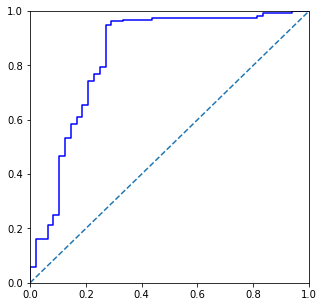

In [28]:
# Print the AUCROC
test_aucroc, (fpr,tpr) = compute_aucroc(final_model, test_dataloader, return_curve=True)
print("Test set AUCROC: ", test_aucroc)

# Plot the ROC curve
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color="blue")
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1],[0,1], "--")
plt.show()

### Remarks

This is a surprisingly high test-set AUC. [A naive comparison to the MoleculeNet leaderboard would place us at number 1.](https://github.com/deepchem/moleculenet#bbbp)

However, it seems likely that the randomization in our scaffold-grouped splits yielded an "easy" test set.
If we had used the same (deterministic) splits as DeepChem's ScaffoldSplitter class, then we would have most likely attained a lower AUC.

To be clear: **I would not compare this AUC to the MoleculeNet leaderboard.** That would be unfair; I suspect my splits gave me an unfair advantage. This was unintentional; I now see that deterministically assigning the largest groups to the training set provides a more rigorous, challenging test set.

# Discussion and conclusions

#### Summary: Data, Model, and Hyperparameters

In this exercise we tackled a supervised learning problem on chemical data.
Specifically, we framed the prediction of blood/brain barrier permeability as a classification task on molecules.

We took care to exercise correct methodology by constructing appropriate train/validation/test splits.
We grouped samples by molecular scaffold, ensuring that pairs of closely-related molecules were always assigned to the same split.
We also stratified the splits by label to further improve the accuracy of our performance estimates.
Furthermore, we preferentially assigned the largest groups to the training set in order to make the evaluation more challenging. 
However, it's worth noting that this was done in a random fashion, in contrast with the DeepChem ScaffoldSplitter (which is deterministic and ultimately yields a harder evaluation).

We wrote a fair amount of code to preprocess the data into a useful form for deep learning.
We used RDKit to translate SMILES strings into one-hot encodings of atoms; thermometer encodings of bonds; and pairwise distance matrices.

We designed and built an attention-based deep neural network to perform the classification task. 
The model's design was informed by basic elements of domain expertise (molecules, atoms, bonds, scaffolds, inverse-squared electric fields), and took inspiration from some well-known graph attention models: [Graph Attention Network (Velickovic et al 2018)](https://arxiv.org/pdf/1710.10903.pdf); [Molecule Attention Transformer (Maziarka et al (2020)](https://arxiv.org/pdf/2002.08264.pdf).

We used a grid search to select model hyperparameters.
Hyperparameter tuning revealed that our self-attention layers were beneficial for generating atom-wise encodings, but were unnecessary for generating atom-wise multiplicative attentions in the final layer.

To sum up, hyperparameter selection chose a _simple_ model out of the class of neural networks I defined.

#### Final evaluation

My test-set AUCROC was higher than expected, given the results on the MoleculeNet leaderboard. 
The most probable cause for this is my randomized algorithm for generating the splits, which contrasts from DeepChem's deterministic algorithm.
So it would be unfair to compare my test-set AUCROC with those on the MoleculeNet leaderboard.
It may be worthwhile to re-run this analysis with DeepChem's splits; however, at this point I am comfortable explaining my mistake and describing the lesson I learned from it.

#### Future work

There are other ideas I would like to pursue:

* The model didn't ultimately use any of the bond information; I would have liked to introduce an additional layer (or augment an existing one) to account for bonds.
* I suspect there are better ways to arrange the layers in this model. I would like to use a more sophisticated search strategy to explore model architectures more thoroughly.
* At some point it would be worthwhile to re-run this analysis with the official splits used by DeepChem.

#### Final remarks

Deep learning (and especially attention-based models) are a very fashionable approach at the moment. Given a large enough budget, it may be possible to build and train such a model that attains state of the art performance on the Blood/Brain Barrier Permeability task. However, it's also worth keeping in mind the effectiveness of much simpler techniques, i.e., tree ensembles on Morgan fingerprints. If this were not explicitly an exercise in "attention-based model," I would have most likely resorted to tree ensembles.

My splits differ from those used on MoleculeNet, so comparing my test-set performance to the MoleculeNet leaderboard would be unfair. To be honest, I wasn't aware of this until after I had run the full analysis. After attaining a surprisingly high test-set AUC, I looked more carefully through DeepChem's ScaffoldSplitter source code and realized how my (randomized) splits differed from their (deterministic) splits. If I were to do this evaluation over again, I would most likely use DeepChem's splitter instead of my own. I decided to leave all of my work in this notebook, as-is, for sake of completeness. I've learned a valuable lesson about grouped splits for molecule data, though.

Predicting blood-brain barrier permeability seems like an interesting challenge. In this exercise we treated it as a classification problem, using only the attributes of the molecule. However, I expect permeability is a function of environmental/contextual attributes in addition to the molecule's isolated attributes. I would guess there are better ways to frame this problem.